## Camera Ops Module

In [1]:
import numpy as np
import subprocess
import glob
import skimage.io as imio
import re
from skimage.color import rgb2gray
import skimage
import matplotlib.pyplot as plt
%matplotlib inline
import time
Time = int(time.time()) % 10000

In [2]:
IP = '10.42.0.215'

def initialFocus(sid=0, ip = IP):
    cmD='ssh nvidia@'+ip+' "echo "nvidia" | sudo -S ~/Documents/cam_on_Tegra/testCamera -id '+str(sid)+' -init "'
    pop=subprocess.run(cmD, stdout=subprocess.PIPE, shell=True)
    return pop.stdout
def moveFocus(sid=0, pos=512, ip = IP):
    cmD='ssh nvidia@'+ip+' "echo "nvidia" | sudo -S ~/Documents/cam_on_Tegra/testCamera -id '+str(sid)+' -mod '+str(pos)+'"'
    pop=subprocess.run(cmD, stdout=subprocess.PIPE, shell=True)
    return pop.stdout
def setFocus(sid=0, pos=512, ip = IP):
    cmD='ssh nvidia@'+ip+' "echo "nvidia" | sudo -S ~/Documents/cam_on_Tegra/testCamera -id '+str(sid)+' -set '+str(pos)+'"'
    pop=subprocess.run(cmD, stdout=subprocess.PIPE, shell=True)
    return pop.stdout

def grab_image(sid=0, imres=8, ip = IP):

    subprocess.run('ssh nvidia@'+ip+' "rm testGrab*"', \
                   stdout=subprocess.PIPE, shell=True)
    subprocess.run('rm testGrab*', \
                    stdout=subprocess.PIPE, shell=True)

    subprocess.run('ssh nvidia@'+ip+' "nvgstcapture-1.0 -m 1 --sensor-id '+str(sid)+' -A --capture-auto 1 \
                    --file-name testGrab --image-res '+str(imres)+'"', stdout=subprocess.PIPE, shell=True)
    subprocess.run('scp nvidia@'+ip+':testGrab* .', \
                   stdout=subprocess.PIPE, shell=True)
    pop=subprocess.run('ls',stdout=subprocess.PIPE, shell=True)
    rePop=pop.stdout
    rePop=rePop.decode("utf-8")
    fileName = re.search(r'testGrab(.*).jpg', rePop)
    fileName=fileName.group()
    pop=imio.imread(fileName)
    pop=skimage.transform.rotate(pop,180)
    
    return pop

In [3]:
# initialFocus()
curr = 800
# setFocus(pos = curr)

# img = grab_image()
# gray_img = rgb2gray(img)

# plt.figure(figsize=(10, 8))
# plt.imshow(img)
# plt.show()

## Autofocus Module

In [4]:
from quad_solver import solver
import torch.nn as nn
import torch.nn.functional as F
import pickle
import cv2
import torch

class pixel_estimator_with_weights(nn.Module):
    def __init__(self, Weights,device = "cuda:0"):
        ## Default: gpu mode
        super(pixel_estimator_with_weights, self).__init__()
        self.device = torch.device(device)
        self.w1 = torch.from_numpy(Weights[0].transpose(3,2,0,1)).to(self.device)
        self.b1 = torch.from_numpy(Weights[1]).to(self.device)
        self.w2 = torch.tensor(Weights[2].transpose(3,2,0,1)).to(self.device)
        self.b2 = torch.tensor(Weights[3]).to(self.device)
        self.w3 = torch.tensor(Weights[4].transpose(3,2,0,1)).to(self.device)
        self.b3 = torch.tensor(Weights[5]).to(self.device)
        self.w4 = torch.tensor(Weights[6]).reshape(4,4,8,1024).permute(3,2,0,1).to(self.device)
        self.b4 = torch.tensor(Weights[7]).to(self.device)
        self.w5 = torch.tensor(Weights[8]).reshape(1,1,1024,512).permute(3,2,0,1).to(self.device)
        self.b5 = torch.tensor(Weights[9]).to(self.device)
        self.w6 = torch.tensor(Weights[10]).reshape(1,1,512,10).permute(3,2,0,1).to(self.device)
        self.b6 = torch.tensor(Weights[11]).to(self.device)
        self.w7 = torch.tensor(Weights[12]).reshape(1,1,10,1).permute(3,2,0,1).to(self.device)
        self.b7 = torch.tensor(Weights[13]).to(self.device)

    def forward(self, x):
        x = F.relu(F.conv2d(x,self.w1,bias = self.b1,stride=1))
        x = F.relu(F.conv2d(x,self.w2,bias = self.b2,stride=1,dilation=8))
        x = F.relu(F.conv2d(x,self.w3,bias = self.b3,stride=1,dilation=32))
        x = F.leaky_relu(F.conv2d(x,self.w4,bias = self.b4,stride=1,dilation=128),0.1)
        x = F.leaky_relu(F.conv2d(x,self.w5,bias = self.b5,stride=1),0.1)
        x = F.leaky_relu(F.conv2d(x,self.w6,bias = self.b6,stride=1),0.1)
        x = F.conv2d(x,self.w7,bias = self.b7,stride=1)
        return x
    
model = torch.load('autofocus.pth')
model.eval()

pixel_estimator_with_weights()

In [5]:
def crop_patches(img, window= 1023, step = 512):
    patches = []
    H, W = img.shape
    for i in range(0, H-step, step):
        for j in range(0, W-step, step):
            patches.append(img[i:i+window, j:j+window])
    return np.stack(patches)

def dist_est(img, last_dist_map = None, last_move_steps = None):
    img = np.pad(img, ((200, 200), (128, 128)), 'reflect')
#     plt.imshow(img)
#     plt.show()
    H, W = img.shape
    
    patches = crop_patches(img)
    patches = torch.from_numpy(patches).float().unsqueeze(1)#.cuda()

    results = []
    with torch.no_grad():
        for i in range(patches.size(0)):
            results.append(model(patches[i:i+1].cuda()).cpu())
    results = torch.stack(results)

    results = results.numpy()
    results = results.squeeze()
    
    if last_dist_map is None:
        last_dist_map = np.ones((H-512, W-512))

    k = 0
    n_img = np.zeros((H-512, W-512))
    for i in range(0, H-512, 512):
        for j in range(0, W-512, 512):
            n_img[i:i+512, j:j+512] = results[k]
            k += 1
    del results
    n_img = np.clip(n_img, 0, 8)
    
    if last_move_steps is not None:
        ## Focus direction: simple check
        mapa = n_img - last_move_steps
        mapb = -n_img - last_move_steps
        diffa = np.abs(mapa) - last_dist_map
        diffb = np.abs(mapb) - last_dist_map
        mask = (np.abs(diffa) < np.abs(diffb)).astype(np.float64)
        n_img = (n_img * mask + (1-mask) * (-n_img))

    return n_img

In [6]:
# n_img = dist_est(gray_img)

In [7]:
# plt.imshow(n_img)
# plt.colorbar()
# plt.show()
# plt.hist(n_img.flatten())
# print(n_img.shape)

## AWnet module

In [8]:
from awnet import pwc_5x5_sigmoid_bilinear   # cm:import AWnet model
import torch
from torchvision import transforms, utils

AWnet = pwc_5x5_sigmoid_bilinear.pwc_residual().cuda()
AWnet.load_state_dict(torch.load('awnet/fs_34_all_0.03036882.pkl'))
AWnet = AWnet.eval()

import warnings
warnings.filterwarnings("ignore")

def fuseTwoImages(I, J_hat):
    with torch.no_grad():
        fusedTensor,warp,mask = AWnet(J_hat,I)
    return fusedTensor#, warp, mask

def patchize(img):
    imgs = []
    H, W, C = img.shape
    ph = H//2
    pw = W//2
    img_empty = np.zeros((H+200, W+200, C))
    img_empty[100:-100, 100:-100] = img
    img = img_empty
    for i in range(2):
        for j in range(2):
            imgs.append(img[100+ph*i-50:100+ph*i+ph+50, 100+pw*j-32:100+pw*j+pw+32])
    imgs = np.stack(imgs)
    return imgs

def depatchize(imgs, pd_h = 50, pd_w = 32):
    ph = (imgs[0].shape[0]-2*pd_h)
    pw = (imgs[0].shape[1]-2*pd_w)
    img = np.zeros((ph*2, pw*2, 3))
    for i in range(2):
        for j in range(2):
            img[i*ph:i*ph+ph, j*pw:j*pw+pw] = imgs[i*2+j, pd_h:-pd_h, pd_w:-pd_w]
            
    return img

def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10,8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
def color_region(tss, locs):
    tensors = tss.clone()
    S, C, H, W = tensors.size()
    assert S == locs.size(0)
    if locs.size(1) == 2:
        for i in range(S):
            loc = locs[i]
            window_size =  min(H, W)//4
            x_l = int((loc[0]+1) * (H - window_size) / 2)
            y_l = int((loc[1]+1) * (W - window_size) / 2)
            x_r = int(min(H, x_l + window_size))
            y_r = int(min(W, y_l + window_size))
            tensors[i][1:, x_l:x_r, y_l:y_r] = -1
            tensors[i][0, x_l:x_r, y_l:y_r] = 1
            tensors[i][:, x_l+25:x_r-25, y_l+25:y_r-25] = tss[i][:, x_l+25:x_r-25, y_l+25:y_r-25]

    return tensors
    

def image_fuse(a, b):
    aa = patchize(a)
    bb = patchize(b)
    aa = torch.Tensor(aa.transpose(0, 3, 1, 2))
    bb = torch.Tensor(bb.transpose(0, 3, 1, 2))

    ccs = []
    #wws = []
    for i in range(4):
        cc = fuseTwoImages(aa[i:i+1].cuda(), bb[i:i+1].cuda())
        ccs.append(cc[0].cpu())
        #wws.append(ww[0])
    cc = torch.stack(ccs)
    #ww = torch.stack(wws)

    c = depatchize(cc.detach().numpy().transpose(0, 2, 3, 1))
    del cc
    #warp = depatchize(ww.cpu().detach().numpy().transpose(0, 2, 3, 1))
    c = np.clip(c, 0, 1)
    return c

## Focus Ctrl Module

In [9]:
import os
from model import *
import warnings
warnings.simplefilter("ignore", UserWarning)
from quad_solver import *
import torchvision
import torch.optim as optim
import torch.nn.functional as F

def load_checkpoint(ckpt_path, model, optimizer):
    
    ckpt_dir = 'ckpt/'+ckpt_path

    print("[*] Loading model from {}".format(ckpt_dir))

    ckpt_dir = '.'
    filename = 'new_model_ckpt.pth.tar'#'rfc_model_best_300.pth.tar' #
    ckpt_path = os.path.join(ckpt_dir, filename)
    ckpt = torch.load(ckpt_path, map_location='cpu')

    # load variables from checkpoint
    start_epoch = ckpt['epoch']
    best_loss = ckpt['best_valid_mse']
    print("current epoch: {} --- best loss: {}".format(start_epoch, best_loss))
    model.load_state_dict(ckpt['model_state'])
    optimizer.load_state_dict(ckpt['optim_state'])   

    return model, optimizer, start_epoch, best_loss

rlmodel = focusLocNet(0.17, 1, 256, 2)#.to("cuda:0")
optimizer= optim.Adam(filter(lambda p: p.requires_grad, rlmodel.parameters()), lr=1e-4)
rlmodel, optimizer, epoch, best_loss = load_checkpoint('best_model', rlmodel, optimizer)
# rlmodel = rlmodel.eval()

def reset():
    h = [torch.zeros(1, 2, 256),#.cuda(),
                  torch.zeros(1, 2, 256)]#.cuda()]
    l = torch.rand(2, 2)*2.0-1.0#.cuda() #-0.5~0.5
    return h, l

def dist_from_region(n_img, loc):
    
    assert len(n_img.shape) == 2

    H, W = n_img.shape
    window_size =  min(H, W)//4

    x_l = int((loc[0]+1) * (H - window_size) / 2)
    y_l = int((loc[1]+1) * (W - window_size) / 2)
    x_r = int(min(H, x_l + window_size))
    y_r = int(min(W, y_l + window_size))

#     dist = -np.mean(n_img[x_l:x_r, y_l:y_r])
    n, bins = np.histogram(n_img[x_l:x_r, y_l:y_r].flatten(), bins=10)
#     n, bins, _ = plt.hist(n_img[x_l:x_r, y_l:y_r].flatten(), bins=10)
#     plt.show()
    idx_sorted = np.argsort(n)[::-1]
    dist = -(bins[idx_sorted[0]]+bins[idx_sorted[0]+1])/2

    return dist

def greedyReward(input_t, locs):
    batch_size, C, H, W = input_t.size()

    rewards = []
    
    for i in range(batch_size):
        loc = locs[i]
        window_size = min(H, W)//4
        x_l = int((loc[0]+1) * (H - window_size) / 2)
        y_l = int((loc[1]+1) * (W - window_size) / 2)
        x_r = int(min(H, x_l + window_size))
        y_r = int(min(W, y_l + window_size))
        if torch.mean(input_t[i][:, x_l:x_r, y_l:y_r]) > 0:
            r = 1
        else:
            r = 0
        rewards.append(r)
    
    rewards = torch.FloatTensor(rewards)
    if input_t.is_cuda:
        rewards = rewards.cuda()
    
    return rewards

[*] Loading model from ckpt/best_model
current epoch: 20 --- best loss: 0.668776384197207


In [10]:
prev_img = None
n_img = None

0
0 th caturing---------- DONOT MOVE!


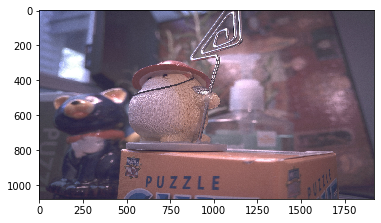

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


rl time: 0.015949487686157227


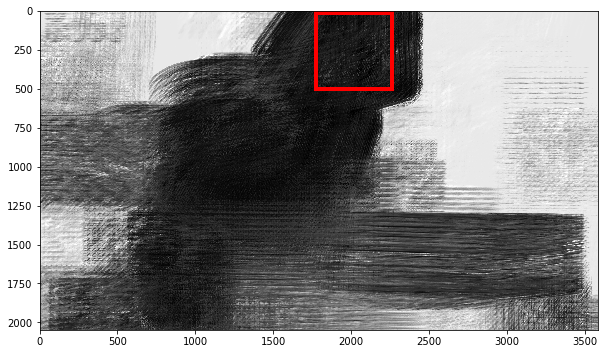

1 th caturing---------- DONOT MOVE!
fuse time: 3.0413849353790283
dist_est time: 8.768174409866333


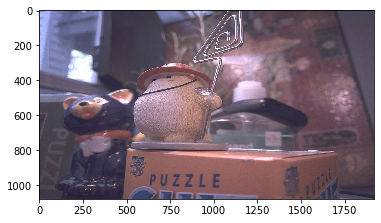

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


rl time: 0.013678789138793945


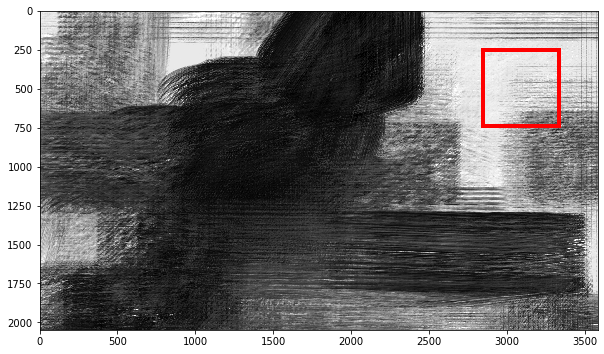

2 th caturing---------- DONOT MOVE!
fuse time: 3.0370969772338867
dist_est time: 8.777260541915894


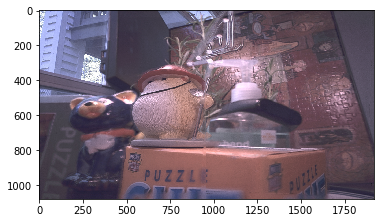

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


rl time: 0.013845443725585938


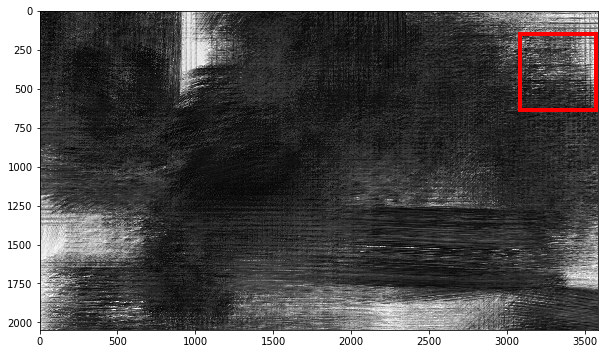

3 th caturing---------- DONOT MOVE!
fuse time: 3.046344757080078
dist_est time: 8.805205821990967


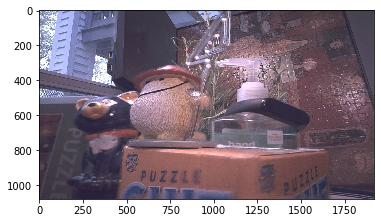

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


rl time: 0.013755083084106445


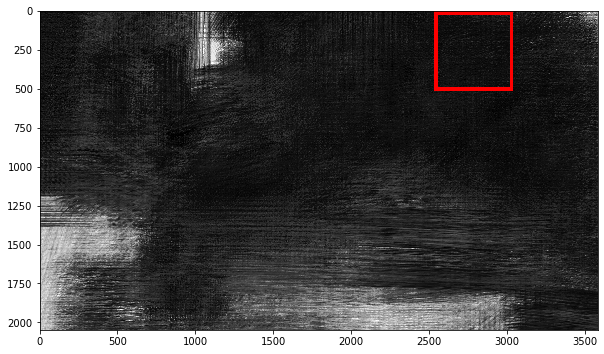

In [11]:
# with torch.no_grad():
iii = 101
        
for epoch in range(1):
    print(epoch)
    prev_img = None
    n_img = None
    h, l = reset()
    curr = 800
    log_pi = []
    baselines = []
    reward = []
    
    for kkk in range(4):
    #     h, l = reset()
        print(kkk, "th caturing---------- DONOT MOVE!")
    #         img = cv2.imread('/home/qian/Documents/datasets/rfc_data/scene/scene1/101/800.jpg')[::-1, ::-1 ,::-1] / 255.0
    #     img = cv2.imread('/home/qian/Documents/datasets/rfc_data/scene/scene1/{}/{}.jpg'.format(iii+kkk, curr))[::-1, ::-1 ,::-1] / 255.0
        img = cv2.imread('/home/qian/Documents/datasets/rfc_data/scene/scene{}/{:03d}/{}.jpg'.format(iii//100, iii+kkk, curr))[::-1, ::-1 ,::-1] / 255.0

    #         cv2.imwrite("rl_frames/oimg{:04d}_{:02d}.png".format(Time, i), (img[...,::-1] * 255.0).astype(np.uint8))
#         print("captured. Move now.")



        if prev_img is None:
            prev_img = cv2.resize(img, None, fx = 0.5, fy = 0.5)
        else:
            ## AWnet 1920 x 1280
            start_time = time.time()
            prev_img = image_fuse(cv2.resize(img, None, fx = 0.5, fy = 0.5), prev_img)
            print("fuse time:", time.time() - start_time)

        gray_img = rgb2gray(img)
        ## AF 3840 x 2160
        if n_img is None:
            n_img = dist_est(gray_img)
        else:
            start_time = time.time()
            n_img = dist_est(gray_img, np.abs(n_img), dist_to_move)
            print("dist_est time:", time.time() - start_time)

    #         cv2.imwrite("rl_frames/fimg{:04d}_{:02d}.png".format(Time, i), (prev_img[...,::-1] * 255.0).astype(np.uint8))

        plt.imshow(prev_img)
        plt.show()

        fused_nimg = dist_est(rgb2gray(cv2.resize(prev_img, None, fx = 2, fy = 2)))
        n_img_resized = (cv2.resize(fused_nimg, (3072, 1536)) /8.0 * 255.0).astype(np.uint8)
        input_t = torch.tensor(n_img_resized/127.5 - 1.0).float().unsqueeze(0).unsqueeze(0)
        ## RL 128x64
        start_time = time.time()

        h, mu, l, b, p = rlmodel(input_t.repeat(2, 1, 1, 1), l, h)#.cuda()
        log_pi.append(p)
        baselines.append(b)
        r = greedyReward(input_t.repeat(2, 1, 1, 1), l)#.cuda()
#         print("reward: ", r)
        reward.append(r)

        print("rl time:", time.time() - start_time)
        dist_to_move = dist_from_region(n_img, l[:1].detach().squeeze().numpy())#.cpu()

        input_show = torch.tensor(fused_nimg/8.0).float().unsqueeze(0).unsqueeze(0)

        n_img_w_region = torchvision.utils.make_grid(color_region(input_show.repeat(1, 3, 1, 1), l[:1].detach()))#.cpu()
        imshow(n_img_w_region)
    #         cv2.imwrite("rl_frames/nimg{:04d}_{:02d}.png".format(Time, i), (n_img_w_region.numpy().transpose(1, 2, 0)[...,::-1] * 255.0).astype(np.uint8))    
        del input_t
        del n_img_w_region

        curr = curr + solver(curr, dist_to_move)        
        curr = np.clip(curr, 450, 1000)
        curr = int(np.round(curr/50)*50)
#         print("next curr: {}, dist to move: {:.1f}".format(curr, dist_to_move))

    baselines = torch.stack(baselines).transpose(1, 0)
    log_pi = torch.stack(log_pi).transpose(1, 0)
    R = torch.stack(reward).transpose(1, 0) * 1.0

    loss_baseline = F.mse_loss(baselines, R)

    adjusted_reward = R - baselines.detach()              

    ## Basic REINFORCE algorithm
    loss_reinforce = torch.sum(-log_pi*adjusted_reward, dim=1)
    loss_reinforce = torch.mean(loss_reinforce, dim=0)

    loss = loss_reinforce + loss_baseline

    ##########---------------???????????????????------------------##########
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [12]:
# def save_checkpoint(state):
#     """
#     Save a copy of the model so that it can be loaded at a future
#     date.
#     """
#     filename = 'new_model_ckpt.pth.tar'
#     torch.save(state, filename)

        
# save_checkpoint(
#                 {'epoch': epoch + 1,
#                  'model_state': rlmodel.state_dict(),
#                  'optim_state': optimizer.state_dict(),
#                  'best_valid_mse': best_loss,
#                  }
#             )
